In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import minimize

In [2]:
c = 2.99792458e+5
omega_v0 = 0.0014
omega_bh2 = 0.02225

In [3]:
def E(z, parameters):   
    omega_m0,h0 = parameters
    h=h0/100
    omega_cb0 = omega_m0 - omega_v0
    #omega=(omega_bh2+omega_ch2+omega_vh2)/h**2
    return ((omega_m0*((1+z)**3)) + 1 - omega_m0)**(1/2)
def f(z,parameters):
    return 1/E(z,parameters)

In [4]:
def Chi_sq1(parameters,H_obs,z_obs,sigma_obs):
    n = z_obs.shape[0]
    H_theo = np.zeros(n)
    omega_m0,Ho = parameters
    chi_sq=0
    for i in range(n):
        H_theo[i]= Ho*(E(z_obs[i],parameters))
        chi_sq= chi_sq+(H_obs[i]-H_theo[i])**2/(sigma_obs[i])**2
    return chi_sq

In [5]:
def dH(parameters,z):
    omega_m0,Ho = parameters
    return c/(Ho*E(z,parameters))
def dM(parameters,z):
    omega_m0,Ho = parameters
    return (c/Ho)*integrate.quad(f,0,(z),args=(parameters,))[0]
def dA(parameters,z):
    omega_m0,Ho = parameters
    return dM(parameters,z)/(1+z)
def dV(parameters,z):
    omega_m0,Ho = parameters
    return (((c/Ho)*((dM(parameters,z))**2)*(z/E(z,parameters)))**(1/3))

In [6]:
def rs(parameters,z):
    omega_m0,Ho = parameters
    h = Ho/100
    num =np.exp(-72.3*(omega_v0*h**2+0.0006)**2)
    den = ((omega_bh2)**(0.12807))*(((omega_m0 - omega_v0)*h**2)**(0.25351))
    return 55.154*num/den

In [7]:
def Chi_sq2(parameters,D_obs,z_obs,cov_mat):
    datapoints= z_obs.shape
    D_theo= np.zeros(datapoints)
    Ho=parameters[1]
    
    dm_indices= [0,2,4]
    h_indices=[3,1,5]
    Dv_indices = [6,8]
    dA_indices = [7]
    dhrs_indices = [9]
    dmrs_indices = [10]
    
    rs_fid= 147.78
    
    for i in Dv_indices:
        if i==6:
            D_theo[i]= dV(parameters,z_obs[i])*147.5/rs(parameters,z_obs[i])
        else:
            D_theo[i]= dV(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in h_indices:
        D_theo[i]=Ho*E(z_obs[i],parameters)*rs(parameters,z_obs[i])/rs_fid
    for i in dm_indices:
        D_theo[i]=dM(parameters,z_obs[i])*rs_fid/rs(parameters,z_obs[i])
    for i in dhrs_indices:
        D_theo[i]=(dH(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dmrs_indices:
        D_theo[i]=(dM(parameters,z_obs[i]))/ rs(parameters,z_obs[i])
    for i in dA_indices:
        D_theo[i]=(dA(parameters,z_obs[i]))/rs(parameters,z_obs[i])
    #print(parameters)
    #print("D_theo1",D_theo)
    #print("D_obs",D_obs)
    D_theo= D_theo-D_obs
    #print("D_theo",D_theo)
    A = np.matmul(np.linalg.inv(cov_mat),D_theo)
    #print("A",A)
    final = (np.matmul(D_theo.T,A))
    #print(final)
    #print(np.linalg.inv(cov_mat))
    #print(final)
    return final[0,0]

In [8]:
def Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs2,cov_matrix):
    #print(Chi_sq3(parameters,H_obs1,z_obs1,sigma_obs1))
    return (Chi_sq2(parameters,D_obs,z_obs2,cov_matrix)+ Chi_sq1(parameters,H_obs1,z_obs1,sigma_obs1))

In [9]:
def lnprior1(parameters):
    omega_m0,Ho = parameters
    if 0.1<=omega_m0<=0.7 and 50<=Ho<=85:
        return 0
    return -np.inf

In [10]:
def log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    return -Chi_sq(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)/2

In [11]:
def log_probability(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix):
    lp = lnprior1(parameters)
    if not np.isfinite(lp):
        return -np.inf
    #print(lp)
    #print(lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix))
    return lp + log_likelihood(parameters,H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix)

In [12]:
Data = pd.read_csv("H(z) data - Sheet1.csv")
z_obs1 = Data['z']
z_obs1 = z_obs1.to_numpy()
z_obs1 = np.reshape(z_obs1,(31,1))
H_obs1 = Data['H(z)']
sigma_obs1 = Data['sigma']
print(Data)
print(z_obs1.shape)

         z   H(z)  sigma
0   0.0700   69.0   19.6
1   0.0900   69.0   12.0
2   0.1200   68.6   26.2
3   0.1700   83.0    8.0
4   0.1790   75.0    4.0
5   0.1990   75.0    5.0
6   0.2000   72.9   29.6
7   0.2700   77.0   14.0
8   0.2800   88.8   36.6
9   0.3520   83.0   14.0
10  0.3802   83.0   13.5
11  0.4000   95.0   17.0
12  0.4004   77.0   10.2
13  0.4247   87.1   11.2
14  0.4497   92.8   12.9
15  0.4700   89.0   50.0
16  0.4783   80.9    9.0
17  0.4800   97.0   62.0
18  0.5930  104.0   13.0
19  0.6800   92.0    8.0
20  0.7810  105.0   12.0
21  0.8750  125.0   17.0
22  0.8800   90.0   40.0
23  0.9000  117.0   23.0
24  1.0370  154.0   20.0
25  1.3000  168.0   17.0
26  1.3630  160.0   33.6
27  1.4300  177.0   18.0
28  1.5300  140.0   14.0
29  1.7500  202.0   40.0
30  1.9650  186.5   50.4
(31, 1)


In [13]:
Data = pd.read_csv("BAO data - Sheet1 (3).csv")
print(Data)
Data['value'][9] = 8.86
Data['value'][10] = 37.41
Data['z'][9] = 2.34
Data['z'][10] = 2.34
#print(Data)

        z      value   sigma
0   0.380  1512.3900     NaN
1   0.380    81.2087     NaN
2   0.510  1975.2200     NaN
3   0.510    90.9029     NaN
4   0.610  2306.6800     NaN
5   0.610    98.9647     NaN
6   0.122   539.0000   17.00
7   0.810    10.7500    0.43
8   1.520  3843.0000  147.00
9   2.334    37.5000     NaN
10  2.334     8.9900     NaN


In [14]:
z_obs = (Data['z'].to_numpy()).astype(float)
z_obs = np.reshape(z_obs, (11,1))
Data = Data.to_numpy()
D_obs = Data[:,1].astype(float)
D_obs = np.reshape(D_obs,(11,1))
print(z_obs.shape)
print(D_obs)

(11, 1)
[[1512.39  ]
 [  81.2087]
 [1975.22  ]
 [  90.9029]
 [2306.68  ]
 [  98.9647]
 [ 539.    ]
 [  10.75  ]
 [3843.    ]
 [   8.86  ]
 [  37.41  ]]


In [15]:
cov_matrix2 = np.matrix([[624.707, 23.729, 325.332, 8.34963, 157.386, 3.57778,0,0,0,0,0],
                    [23.729, 5.60873, 11.6429, 2.33996, 6.39263, 0.968056,0,0,0,0,0],
                    [325.332, 11.6429, 905.777, 29.3392, 515.271, 14.1013,0,0,0,0,0],
                    [8.34963, 2.33996, 29.3392, 5.42327, 16.1422, 2.85334,0,0,0,0,0],
                    [157.386, 6.39263, 515.271, 16.1422, 1375.12, 40.4327,0,0,0,0,0],
                    [3.57778, 0.968056, 14.1013, 2.85334, 40.4327, 6.25936,0,0,0,0,0],
                    [0,0,0,0,0,0,17**2,0,0,0,0],
                     [0,0,0,0,0,0,0,0.43**2,0,0,0],
                     [0,0,0,0,0,0,0,0,147**2,0,0],
                     [0,0,0,0,0,0,0,0,0,0.0841,-0.183396],
                     [0,0,0,0,0,0,0,0,0,-0.183396,3.4596]])

In [17]:
initial = np.array([0.024, 70]) 
soln = minimize(Chi_sq, initial, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2),bounds=[(0,1),(0,np.inf)])
print(soln)

      fun: 20.819575278769598
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.19744231e-06, -3.55271591e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 48
      nit: 15
     njev: 16
   status: 0
  success: True
        x: array([ 0.31375517, 68.53477985])


In [20]:
import emcee
p0 = soln.x + 1e-4 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(H_obs1,z_obs1,sigma_obs1,D_obs,z_obs,cov_matrix2))

In [21]:
pos, prob, state = sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [17:57<00:00,  1.86it/s]


In [22]:
sampler.reset()

In [23]:
sampler.run_mcmc(pos, 20000, progress=True)
##Sampler runs for a total of 20000 steps.

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [3:14:58<00:00,  1.71it/s]


State([[ 0.30520192 68.55057075]
 [ 0.3202458  68.46939714]
 [ 0.31455156 68.47127981]
 [ 0.29724294 69.2907241 ]
 [ 0.33360695 67.81954164]
 [ 0.32853013 69.1411015 ]
 [ 0.3160293  68.13002928]
 [ 0.28577527 67.79053075]
 [ 0.332709   68.18875182]
 [ 0.31526539 68.5329664 ]
 [ 0.30808114 67.47663553]
 [ 0.32165082 67.85761463]
 [ 0.3337012  69.04733087]
 [ 0.30082508 68.49182132]
 [ 0.30176318 68.57307903]
 [ 0.29371708 69.66570027]
 [ 0.30013591 68.07792351]
 [ 0.30951321 67.84854124]
 [ 0.28740671 67.47224232]
 [ 0.33065567 68.77015275]
 [ 0.29230341 68.29729052]
 [ 0.31506814 68.13505436]
 [ 0.3219371  69.38448426]
 [ 0.31488333 68.868269  ]
 [ 0.31068211 68.01762703]
 [ 0.29348334 68.28743962]
 [ 0.33674525 68.29184387]
 [ 0.31454462 69.69519895]
 [ 0.30376146 68.61895435]
 [ 0.3251112  68.66130395]
 [ 0.32112582 66.42775915]
 [ 0.32767815 68.06111488]
 [ 0.32289014 69.79901878]
 [ 0.3188516  67.67924077]
 [ 0.32089533 67.95235887]
 [ 0.32169444 68.99197566]
 [ 0.29838692 68.94186

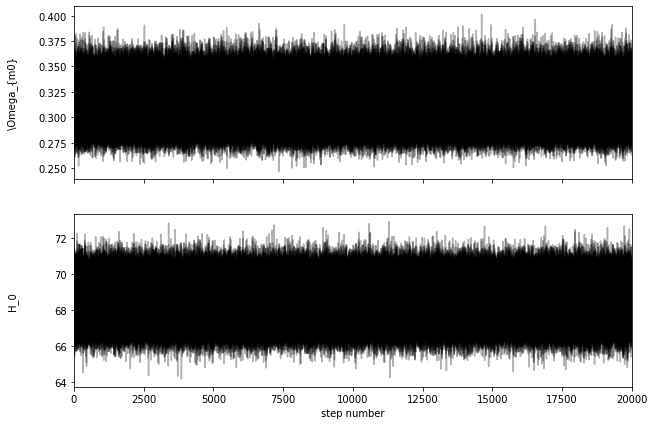

In [24]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["\Omega_{m0}", "H_0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [25]:
tau = sampler.get_autocorr_time()
print(tau)

[31.16598951 31.42188124]


In [23]:
samples = sampler.get_chain()

In [26]:
samples.shape

(20000, 200, 2)

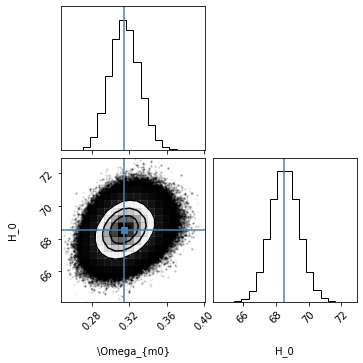

In [27]:
flat_samples = sampler.get_chain(flat=True)
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=soln.x
);

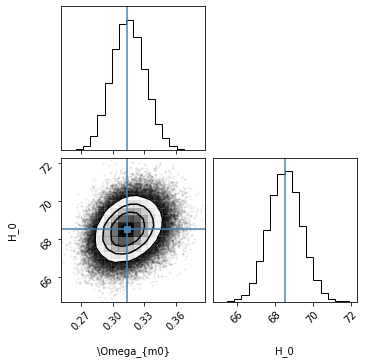

In [26]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=soln.x
);

In [28]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
from getdist import plots, MCSamples
import getdist
import matplotlib.pyplot as plt
import IPython
print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))

GetDist Version: 1.4.3, Matplotlib version: 3.5.2


In [30]:
names = ["omega_m02","Ho"]
labels =  ["\Omega_{m0}", "H_0"]
samples2 = MCSamples(samples=flat_samples,names = names, labels = labels)

Removed no burn in


In [31]:
means = samples2.getMeans()
stats = samples2.getMargeStats()
conf_levels = samples2.contours

In [32]:
print(means)
mcmc

[ 0.31474815 68.54326002]


array([67.67659627, 68.54166328, 69.41029755])

In [33]:
lims0 = stats.parWithName('omega_m02').limits
lims1 = stats.parWithName('Ho').limits

In [40]:
for conf, lim0, lim1 in zip(samples2.contours,lims0, lims1):
        #print(lim0.lower,mcmc1[1])
        if conf != 0.6827:
            continue
            
        print('value: %.3f, lower: %.3f, upper: %.3f'%(means[0], lim0.lower - means[0], lim0.upper- means[0]))
        print('value: %.2f, lower: %.2f, upper: %.2f'%(means[1], lim1.lower - means[1], lim1.upper - means[1]))

value: 0.315, lower: -0.016, upper: 0.015
value: 68.54, lower: -0.87, upper: 0.87


<Figure size 432x324 with 0 Axes>

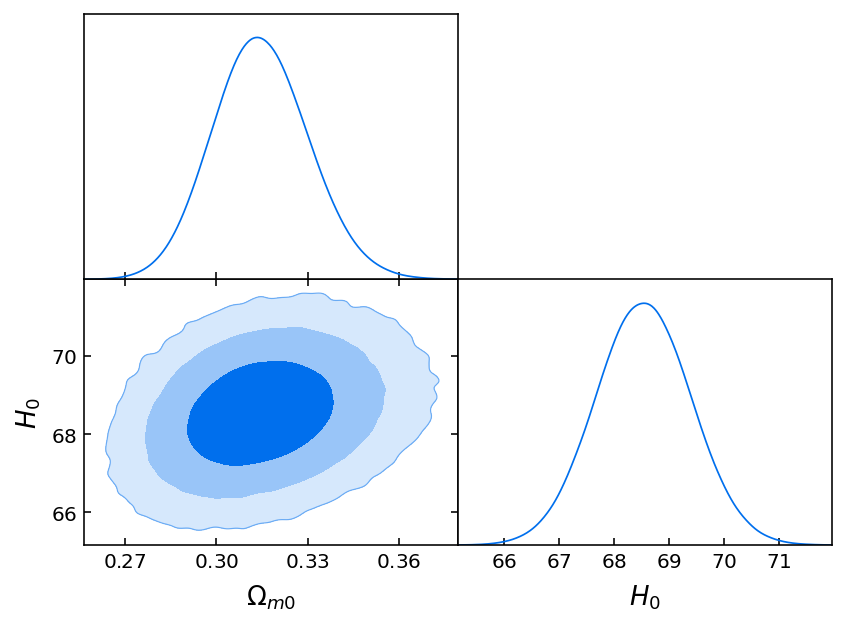

In [38]:
g = plots.get_single_plotter()
samples2.updateSettings({'contours': [0.6827, 0.9545, 0.9973]})
g.settings.num_plot_contours = 4
g.triangle_plot([samples2], filled=True);